In [2]:
from pathlib import Path

from pyspark.sql.session import SparkSession
from pyspark.sql import DataFrame

MAX_MEMORY = "5g"
spark = (
    SparkSession.builder.master("local[*]")
    .appName("TripAnaliysis")
    .config("spark.excutor.memory", MAX_MEMORY)
    .config("spark.driver.memory", MAX_MEMORY)
    .getOrCreate()
)


24/04/27 16:23:21 WARN Utils: Your hostname, limhaneul-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.66 instead (on interface en0)
24/04/27 16:23:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/27 16:23:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/27 16:23:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/27 16:23:23 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [9]:
import os

def parquet_file_all(year: int) -> list[str]:
    return Path(os.path.dirname(os.getcwd())).joinpath(f"data/{str(year)}")

file_data = parquet_file_all(2019)
file_data

PosixPath('/Users/imhaneul/Documents/project/spark-kafka-distribute/sparkAnaliysis/data/2019')

In [13]:
"""
[PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-02.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-03.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-04.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-05.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-06.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-07.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-08.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-09.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-10.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-11.parquet'),
 PosixPath('/Users/imhaneul/Documents/spark-kafka-distribute/sparkAnaliysis/data/2019/fhvhv_tripdata_2019-12.parquet')]
"""
from pyspark.sql.functions import col
from pyspark.sql import functions as F

data = parquet_file_all(2019)
data = spark.read.parquet(f"file:///{data}/*")

In [14]:
def datetime_groupby(data: DataFrame, name: str, agg_name: str) -> DataFrame:
    return (
        data.select(F.split(col(name), " ")[0].name("pickup"))
        .dropna()
        .groupBy("pickup")
        .agg(F.count("*").name(agg_name))
    )

def datetime_miles_average(data: DataFrame) -> DataFrame:
    return (data.select(F.split(col("pickup_datetime"), " ")[0].name("pickup"), col("trip_miles"))
        .groupBy("pickup") 
        .agg(
            F.count("pickup").name("pickup_total"), 
            F.avg("trip_miles").name("average_miles")
        ) 
    )

In [15]:

request_groupby = datetime_groupby(data, "request_datetime", "request_count")
trip_groupby = datetime_groupby(data, "pickup_datetime", "trip_count")
drop_groupby = datetime_groupby(data, "dropoff_datetime", "drop_count")
average_mile = datetime_miles_average(data)

rtd_join = (
    trip_groupby
    .join(request_groupby, on="pickup", how="left")
    .join(drop_groupby, on="pickup", how="left")
    .join(average_mile, on="pickup", how="left")
).orderBy("pickup")

week_day_rtd_join = (
    rtd_join.select(
        F.date_format(col("pickup"), "EEEE").alias("week"),
        F.dayofweek(col("pickup")).alias("week_number"),
        col("pickup"), 
        col("trip_count"), 
        col("request_count"), 
        col("drop_count"),
        col("average_miles")
    )
).toPandas()

In [16]:

import matplotlib.pyplot as plt 
import seaborn as sns

week_day_rtd_join.to_csv("test.csv", index=False)
# group_date_average_mlies = week_day_rtd_join.groupby("week").average_miles.mean().to_frame().reset_index()
# group_date_average_mlies["sort_dow"] = group_date_average_mlies["week"].replace({
#     "Sunday": 0,
#     "Monday": 1,
#     "Tuesday": 2,
#     "Wednesday": 3,
#     "Thursday": 4,
#     "Friday": 5,
#     "Saturday": 6,  
# })
# group_date_average_mlies

In [ ]:
group_date_trip = week_day_rtd_join.groupby("week").trip_count.mean().to_frame().reset_index()
group_date_trip["sort_dow"] = group_date_trip["week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,  
})
group_date_trip

/var/folders/bp/0rpm363x6v5_d67px2lrg02w0000gn/T/ipykernel_5908/1026961289.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_date_trip["sort_dow"] = group_date_trip["week"].replace({


,week,trip_count,sort_dow
0,Friday,715295.187500,5
1,Monday,638480.250000,1
2,Saturday,805233.416667,6
3,Sunday,834266.479167,0
4,Thursday,670425.404255,4
5,Tuesday,605803.479167,2
6,Wednesday,632593.479167,3


/var/folders/bp/0rpm363x6v5_d67px2lrg02w0000gn/T/ipykernel_5908/225955858.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="week", y="average_miles", data=group_date_average_mlies.sort_values("sort_dow"), ax=ax[0], palette='husl', legend=False)
/var/folders/bp/0rpm363x6v5_d67px2lrg02w0000gn/T/ipykernel_5908/225955858.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="week", y="trip_count", data=group_date_trip.sort_values("sort_dow"), ax=ax[1], palette='husl', legend=False)


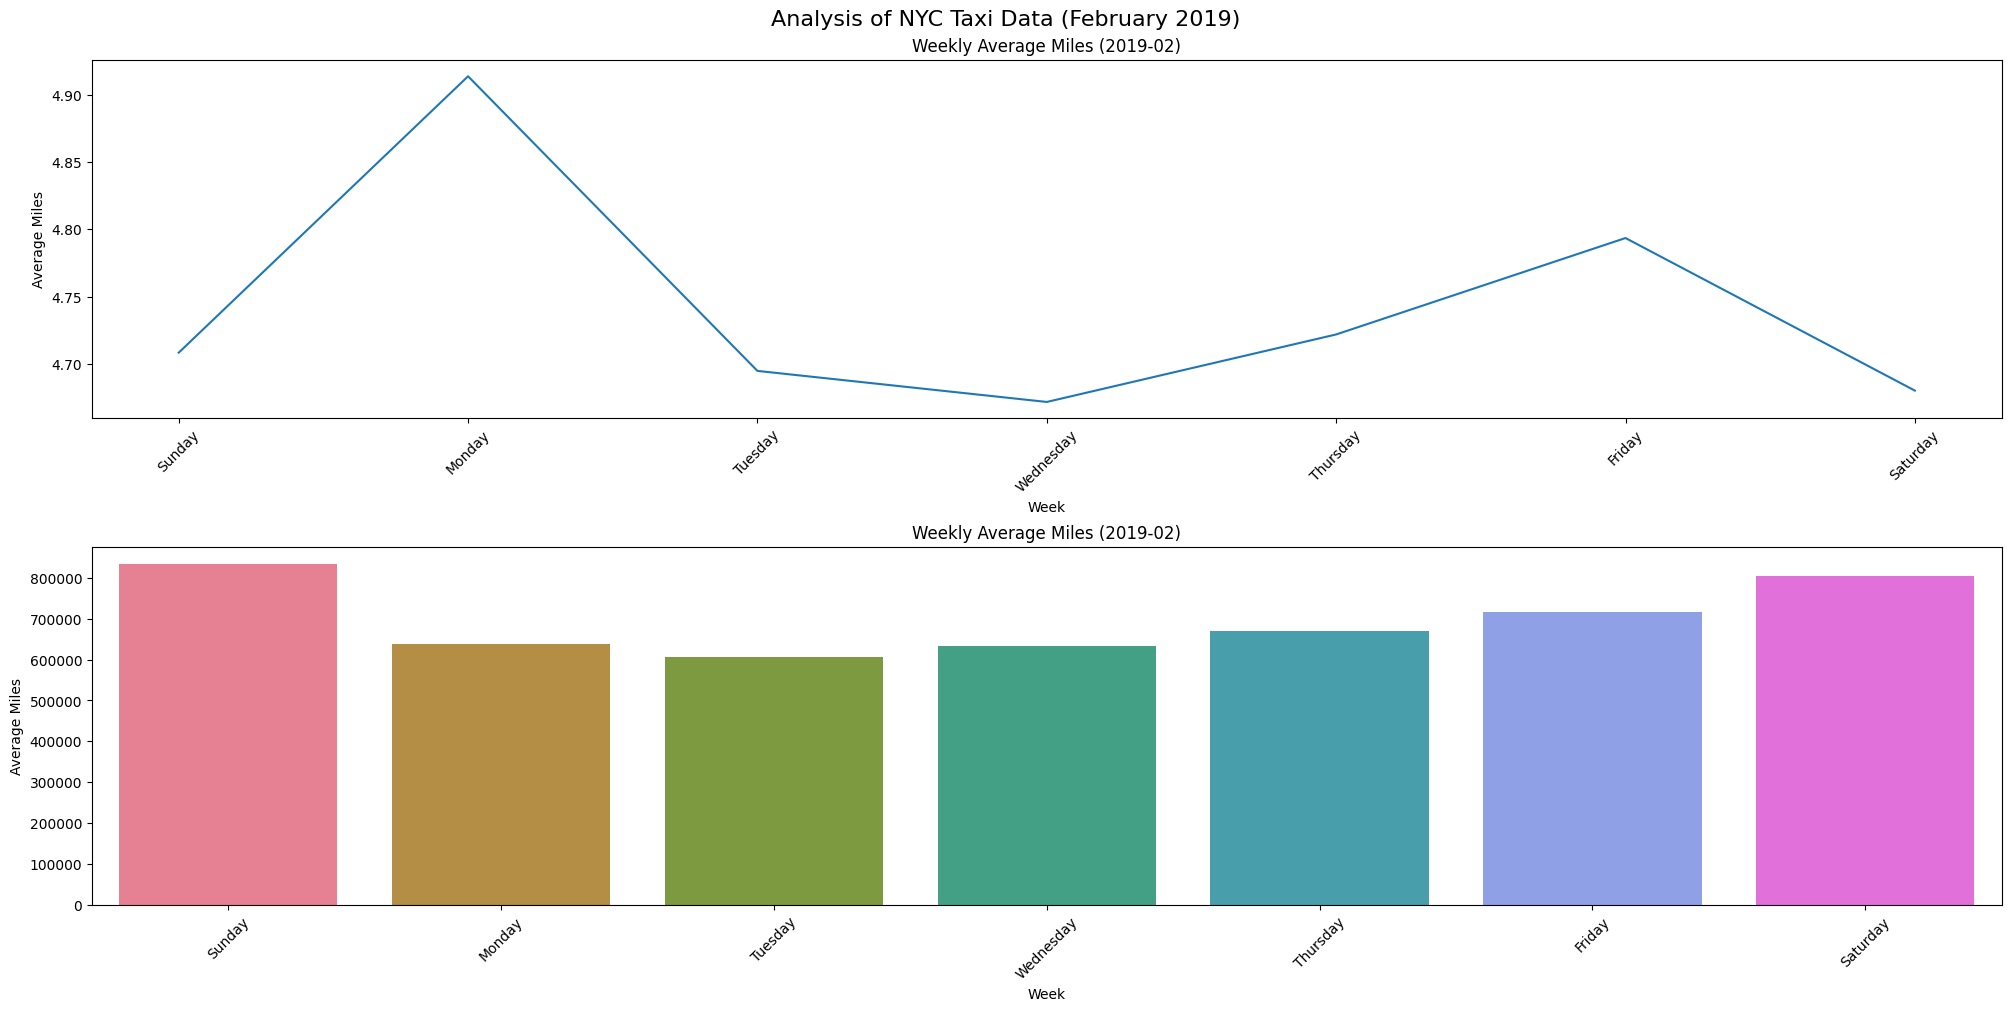

In [ ]:
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 10), constrained_layout=True)

# Plot 2: Weekly average miles
sns.lineplot(x="week", y="average_miles", data=group_date_average_mlies.sort_values("sort_dow"), ax=ax[0], palette='husl', legend=False)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlabel("Week")
ax[0].set_ylabel("Average Miles")
ax[0].set_title("Weekly Average Miles (2019-02)")

# Plot 2: Weekly average miles
sns.barplot(x="week", y="trip_count", data=group_date_trip.sort_values("sort_dow"), ax=ax[1], palette='husl', legend=False)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Week")
ax[1].set_ylabel("Average Miles")
ax[1].set_title("Weekly Average Miles (2019-02)")
# Overall Title
plt.suptitle("Analysis of NYC Taxi Data (February 2019)", fontsize=16)

# Show plot
plt.show()

In [21]:
spark.stop()